In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
n225_df = pd.read_csv('./data/nikkei_stock_average_daily_jp.csv',
                      parse_dates=True, index_col=['Date'])
vi_df = pd.read_csv('./data/nikkei_stock_average_vi_daily_jp.csv',
                    parse_dates=True, index_col=['Date'])

n225_vi_df = pd.concat([n225_df['Close'], vi_df['Close']], axis=1)
n225_vi_df.columns = ['n225', 'VI']
n225_vi_df.dropna(inplace=True)

s_df = pd.read_pickle('./data/s.pickle')
op_pn1 = pd.read_pickle('./data/op1.pickle')
op_pn2 = pd.read_pickle('./data/op2.pickle')
op_pn = {'1803': op_pn1, '1804': op_pn2}

### ボラティリティの特性

* 権利行使価格ごとに異なる
* プットのIV > コールのIV
* ATM付近が最も低くなる

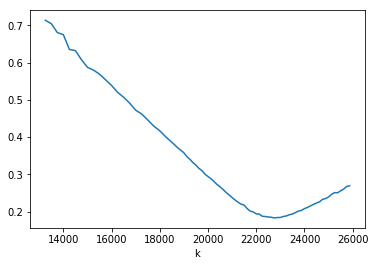

In [3]:
op_pn['1803'].loc['2018-02-16 15:15']['iv'].plot();

### ボラティリティの変化

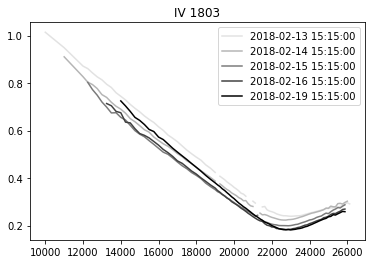

In [4]:
n = 5
periods = op_pn['1803'].keys()
colors = plt.get_cmap('Greys')(np.linspace(0, 1, n + 1))[1:]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(n):
    label = periods[i]
    x = op_pn['1803'].loc[periods[i]].index
    y = op_pn['1803'].loc[periods[i]]['iv']
    ax.plot(x, y, color=colors[i], label=label)

ax.set_title('IV 1803')
ax.legend()
plt.show()

* 権利行使価格が多数ある
* 限月が複数ある
* 全てのデータを時系列に並べるのは非現実的
* 一つの指標としてまとまったものがあると便利

### 日経平均ボラティリティー・インデックス

* オプションのプレミアムを元に算出した指標
* 日経平均株価の将来の変動をどのように想定しているかがわかる
* 満期が30日になるように線形補間

> 参考: 日経平均プロフィル -> 日経平均ボラティリティー・インデックス  
> https://indexes.nikkei.co.jp/nkave/index/profile?idx=nk225vi

### 時系列データ

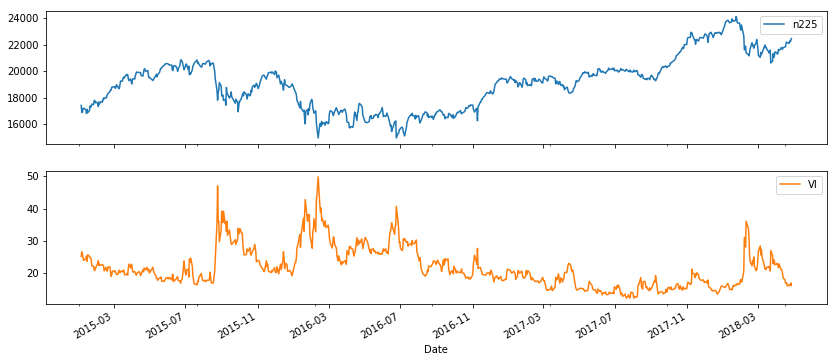

In [5]:
n225_vi_df.dropna().plot(subplots=True, figsize=(14, 6));

* ボラティリティが急激に上昇したら、急激に下落する  
  -> ボラティリティスパイク
* 平均回帰性
* 原資産価格の変動と比較して、特性があり動きが読みやすい

### VIと移動平均

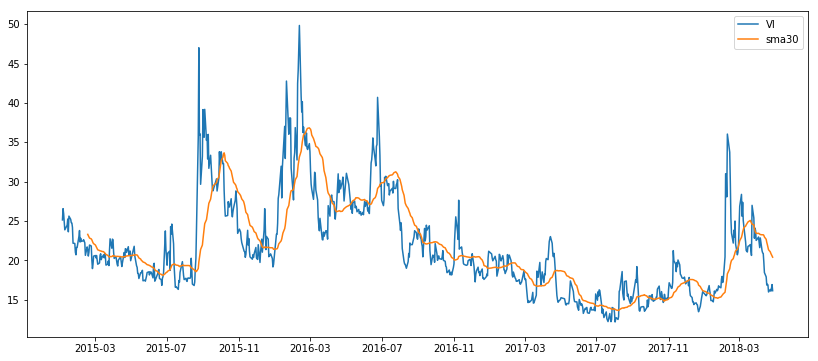

In [6]:
window = 30
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(vi_df['Close'], label='VI')
ax.plot(vi_df['Close'].rolling(window).mean(), label='sma{}'.format(window))
ax.legend();

### VIのシステムトレード
* 移動平均から上に乖離したらショート
* 移動平均から下に乖離したらロング

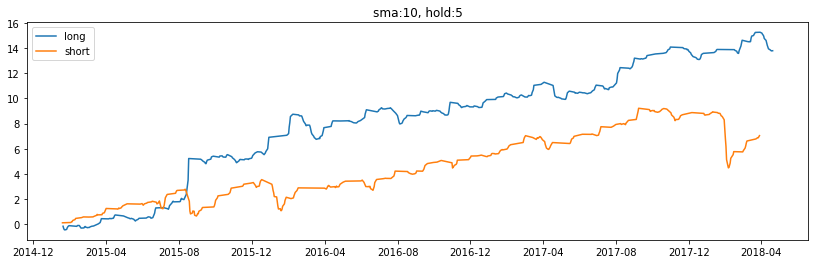

In [7]:
window = 10
days_after = 5

df = pd.DataFrame([vi_df['Close'] - vi_df['Close'].rolling(window).mean(),
                   vi_df['Close'].pct_change(days_after).shift(-days_after)
                  ]).T
df.columns = ['distance', 'days_after']
df.dropna(inplace=True)

short_returns = (df.loc[df['distance'] > 0, 'days_after'] * -1).cumsum()
long_returns = df.loc[df['distance'] < 0, 'days_after'].cumsum()

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(long_returns, label='long')
ax.plot(short_returns, label='short')
ax.set_title('sma:{}, hold:{}'.format(window, days_after))
ax.legend();

### 日経平均株価とVIの関係(騰落率)

'corr: -0.6799338271926186'

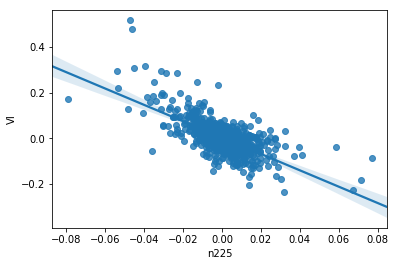

In [8]:
n225_vi_diff_df = n225_vi_df.pct_change().dropna()
sns.regplot(x='n225', y='VI', data=n225_vi_diff_df);
'corr: {}'.format(n225_vi_diff_df.corr().iloc[0, 1])

In [9]:
model = sm.OLS(n225_vi_diff_df['VI'], n225_vi_diff_df['n225'])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     VI   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     694.1
Date:                Thu, 21 Jun 2018   Prob (F-statistic):          4.44e-111
Time:                        16:36:22   Log-Likelihood:                 1266.1
No. Observations:                 814   AIC:                            -2530.
Df Residuals:                     813   BIC:                            -2525.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
n225          -3.5750      0.136    -26.346      0.000      -3.841      -3.309
==============================================================================
Omnibus:                      210.035   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.659
Skew:                           1.044   Prob(JB):                    9.37e-258
Kurtosis:                       8.526   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* 日経平均株価とVIには負の相関がある
* 特に原資産価格が急落した場合にはボラティリティが上昇しやすい

### イベント盛り

* 相場が凪の状態でも、直近で動きそうなイベントが控えている場合には先行してボラティリティが上昇する
  - 選挙
  - 中央銀行政策金利発表
  - 重要経済指標(雇用統計など)

* 大きなイベントほど、ボラティリティが上昇するタイミングが早くなる
* どのイベントが注目されるかは時期によって異なる

### イベント通過剥げ

* イベントで上昇したボラティリティが、イベントを通過することで下落する  
* イベント前にオプションを売っても必ずしも儲かるとは限らない

### 非農業部門雇用者数

* NFP(Non Farm Payroll)と呼ばれる  
  失業率も同じタイミングで発表される
* 経済指標の中でも重要度が高い
* 今後の政策金利に影響する
* 最近はあまり重要視されていない

### 非農業部門雇用者数とVI    

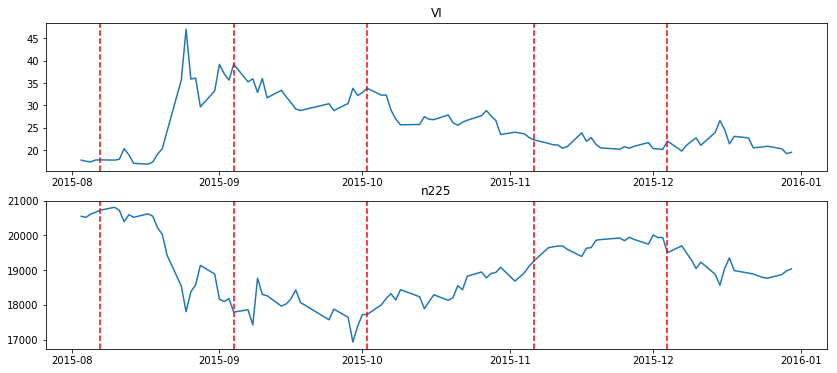

In [11]:
from io import StringIO

# https://www.investing.com/economic-calendar/nonfarm-payrolls-227
text = """
Release Date	Time	Actual	Forecast	Previous	
Jul 06, 2018 (Jun)	08:30	 	188K	223K	
Jun 01, 2018 (May)	08:30	223K	189K	159K	
May 04, 2018 (Apr)	08:30	164K	189K	135K	
Apr 06, 2018 (Mar)	08:30	103K	193K	326K	
Mar 09, 2018 (Feb)	09:30	313K	200K	239K	
Feb 02, 2018 (Jan)	09:30	200K	184K	160K	
Jan 05, 2018 (Dec)	09:30	148K	190K	252K	
Dec 08, 2017 (Nov)	09:30	228K	200K	244K	
Nov 03, 2017 (Oct)	08:30	261K	310K	18K	
Oct 06, 2017 (Sep)	08:30	-33K	90K	169K	
Sep 01, 2017 (Aug)	08:30	156K	180K	189K	
Aug 04, 2017 (Jul)	08:30	209K	183K	231K	
Jul 07, 2017 (Jun)	08:30	222K	179K	152K	
Jun 02, 2017 (May)	08:30	138K	185K	174K	
May 05, 2017 (Apr)	08:30	211K	185K	79K	
Apr 07, 2017 (Mar)	08:30	98K	180K	219K	
Mar 10, 2017 (Feb)	09:30	235K	200K	238K	
Feb 03, 2017 (Jan)	09:30	227K	175K	157K	
Jan 06, 2017 (Dec)	09:30	156K	178K	204K	
Dec 02, 2016 (Nov)	09:30	178K	175K	142K	
Nov 04, 2016 (Oct)	08:30	161K	175K	191K	
Oct 07, 2016 (Sep)	08:30	156K	175K	167K	
Sep 02, 2016 (Aug)	08:30	151K	180K	275K	
Aug 05, 2016 (Jul)	08:30	255K	180K	292K	
Jul 08, 2016 (Jun)	08:30	287K	175K	11K	
Jun 03, 2016 (May)	08:30	38K	164K	123K	
May 06, 2016 (Apr)	08:30	160K	202K	208K	
Apr 01, 2016 (Mar)	08:30	215K	205K	245K	
Mar 04, 2016 (Feb)	09:30	242K	190K	172K	
Feb 05, 2016 (Jan)	09:30	151K	190K	262K	
Jan 08, 2016 (Dec)	09:30	292K	200K	252K	
Dec 04, 2015 (Nov)	09:30	211K	200K	298K	
Nov 06, 2015 (Oct)	09:30	271K	180K	137K	
Oct 02, 2015 (Sep)	08:30	142K	203K	136K	
Sep 04, 2015 (Aug)	08:30	173K	220K	245K	
Aug 07, 2015 (Jul)	08:30	215K	223K	231K	
Jul 02, 2015 (Jun)	08:30	223K	230K	254K	
Jun 05, 2015 (May)	08:30	280K	225K	221K	
May 08, 2015 (Apr)	08:30	223K	224K	85K	
Apr 03, 2015 (Mar)	08:30	126K	245K	264K	
Mar 06, 2015 (Feb)	09:30	295K	240K	239K	
Feb 06, 2015 (Jan)	09:30	257K	234K	329K	
Jan 09, 2015 (Dec)	09:30	252K	240K	353K	
Dec 05, 2014 (Nov)	09:30	321K	225K	243K	
Nov 07, 2014 (Oct)	09:30	214K	231K	256K	
Oct 03, 2014 (Sep)	08:30	248K	215K	180K	
Sep 05, 2014	08:30	142K	225K	212K	
Aug 01, 2014	08:30	209K	233K	298K	
Jul 03, 2014	08:30	288K	212K	224K	
Jun 06, 2014	08:30	217K	218K	282K	
May 02, 2014	08:30	288K	210K	203K	
Apr 04, 2014	08:30	192K	200K	197K	
Mar 07, 2014	09:30	175K	149K	129K	
Feb 07, 2014	09:30	113K	185K	75K	
Jan 10, 2014	09:30	74K	196K	241K	
Dec 06, 2013	09:30	203K	180K	200K	
Nov 08, 2013	09:30	204K	125K	163K	
Oct 22, 2013	08:30	148K	180K	193K	
Sep 06, 2013	08:30	169K	180K	104K	
Aug 02, 2013	08:30	162K	184K	188K	
Jul 05, 2013	08:30	195K	165K	195K	
Jun 07, 2013	08:30	175K	170K	149K	
May 03, 2013	08:30	165K	145K	138K	
Apr 05, 2013	08:30	88K	200K	268K	
Mar 08, 2013	09:30	236K	160K	119K	
Feb 01, 2013	09:30	157K	160K	196K	
Jan 04, 2013	09:30	155K	150K	161K	
Dec 07, 2012	09:30	146K	93K	138K	
Nov 02, 2012	08:30	171K	125K	148K	
Oct 05, 2012	08:30	114K	113K	142K	
Sep 07, 2012	08:30	96K	125K	141K	
Aug 03, 2012	08:30	163K	100K	64K	
Jul 06, 2012	08:30	80K	90K	77K	
Jun 01, 2012	08:30	69K	150K	77K	
May 04, 2012	08:30	115K	170K	154K	
Apr 06, 2012	08:30	120K	203K	240K	
Mar 09, 2012	09:30	227K	210K	284K	
Feb 03, 2012	09:30	243K	150K	203K	
Jan 06, 2012	09:30	200K	150K	100K	
Dec 02, 2011	09:30	120K	120K	100K	
Nov 04, 2011	08:30	80K	95K	158K	
Oct 07, 2011	08:30	103K	53K	57K	
Sep 02, 2011	08:30	0K	74K	85K	
Aug 05, 2011	08:30	117K	95K	46K	
Jul 08, 2011	08:30	18K	89K	25K	
Jun 03, 2011	08:30	54K	169K	232K	
May 06, 2011	08:30	244K	185K	221K	
Apr 01, 2011	08:30	216K	188K	194K	
Mar 04, 2011	09:30	192K	180K	63K	
Feb 04, 2011	09:30	36K	150K	121K	
Jan 07, 2011	09:30	103K	150K	71K	
Dec 03, 2010	09:30	39K	140K	172K	
Nov 05, 2010	08:30	151K	60K	-41K	
Oct 08, 2010	08:30	-95K	3K	-57K	
Sep 03, 2010	08:30	-54K	-118K	-54K	
Aug 06, 2010	08:30	-131K	-65K	-221K	
Jul 02, 2010	08:30	-125K	-100K	433K	
Jun 04, 2010	08:30	431K	500K	290K	
May 07, 2010	08:30	290K	187K	230K	
Apr 02, 2010	08:30	162K	190K	-14K	
Mar 05, 2010	09:30	-36K	-55K	-26K	
Feb 05, 2010	09:30	-20K	15K	-150K	
Jan 08, 2010	09:30	-85K	0K	4K	
"""

nfp_df = pd.read_csv(StringIO(text), sep='\t')
nfp_date = nfp_df['Release Date'].map(lambda x: pd.to_datetime(x.split('(')[0]))
nfp_date.sort_values(inplace=True)
nfp_date = pd.Series(nfp_date.values, index=nfp_date.values)

loc = slice('2015-08', '2015-12')
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(n225_vi_df['VI'].loc[loc])
ax2.plot(n225_vi_df['n225'].loc[loc])
for d in nfp_date.loc[loc]:
    ax1.axvline(d, color='red', linestyle='--')
    ax2.axvline(d, color='red', linestyle='--')
ax1.set_title('VI')
ax2.set_title('n225');